### Bayesian Statistics Project

Rémi LACOSTE
& Guillaume RIGAUD

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sn
from scipy.stats import gamma
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

# 0. Introduction to data

In [2]:
# Data is available at : 
# https://www.kaggle.com/campbellsinvestment/jamaican-islandwide-fever-and-respiratory-symptoms
data = pd.read_csv("Islandwide-Fever-and-Respiratory-Symptoms.csv")

In [3]:
print(data.head())  
print('---------------------------------------------')
print('Weekly data from', min(data['Year']), 'to', max(data['Year']))

   Year      Age Range  Epidemiological Week  Fever and Respiratory Symptoms
0  2008  5 and younger                     1                             453
1  2008  5 and younger                     2                             442
2  2008  5 and younger                     3                             552
3  2008  5 and younger                     4                             688
4  2008  5 and younger                     5                             649
---------------------------------------------
Weekly data from 2008 to 2016


In [4]:
print(data.groupby( ['Age Range','Year'] , as_index=False)['Epidemiological Week'].count())
print('---------------------------------------------')
print("2014 is missing and 2013 is not complete")

        Age Range  Year  Epidemiological Week
0   5 and younger  2008                    52
1   5 and younger  2009                    52
2   5 and younger  2010                    52
3   5 and younger  2011                    52
4   5 and younger  2012                    52
5   5 and younger  2013                    50
6   5 and younger  2015                    52
7   5 and younger  2016                    11
8            5-59  2008                    52
9            5-59  2009                    52
10           5-59  2010                    52
11           5-59  2011                    52
12           5-59  2012                    52
13           5-59  2013                    50
14           5-59  2015                    52
15           5-59  2016                    11
16   60 and older  2008                    52
17   60 and older  2009                    52
18   60 and older  2010                    52
19   60 and older  2011                    52
20   60 and older  2012           

In [5]:
#Erase last years
data = data.loc[data['Year'] <= 2013]

data.columns = ['Year', 'Age', 'Week', 'N_victims']
df_young = data[ data["Age"] == "5 and younger" ].copy()
df_middle = data[ data["Age"] == "5-59"].copy()
df_old = data[ data["Age"] == '60 and older'].copy()

n = np.shape(df_young)[0]
print("we have in total", n, "weekly observations per age group")
n_train = 52*4 # 4 years for train set, 2 for test set
x = np.linspace(1, n , n)

we have in total 310 weekly observations per age group


Studying the database, we will answer the following questions:
1. Is there a link between the number of victims and the age category? With models by age category, can we predict the number of victims? 
2. Is there a particular seasonal trend ? Can we capture it and predict faithfully the number of victims?  </p>

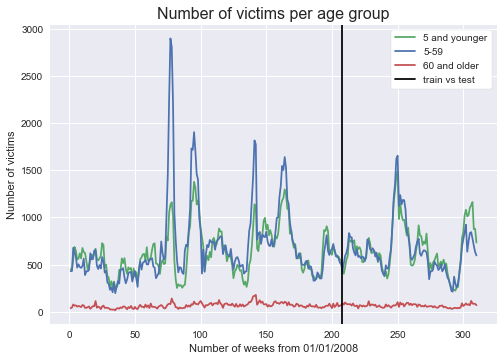

In [6]:
plt.plot(x, df_young['N_victims'],  color = 'C1')
plt.plot(x, df_middle['N_victims'], color = 'C0')
plt.plot(x, df_old['N_victims'], color ='C2')
plt.axvline(x = n_train, color = 'black')
plt.legend(['5 and younger', '5-59', '60 and older', 'train vs test'], frameon=True, facecolor='white', framealpha = 1)
plt.title("Number of victims per age group", fontsize=16)
plt.xlabel("Number of weeks from 01/01/2008")
plt.ylabel("Number of victims");
#plt.savefig('weekly_victims')

# 1.  Processus de comptage

In [7]:
print("Mean of weekly number of victims :", "%.0f" % np.mean(data['N_victims']))
print("Variance of weekly number of victims :", "%.0f" % np.var(data['N_victims']))
print()
print('---------------------------------------------------------------')
print()
pd.options.display.float_format = '{:.0f}'.format
print('Mean of weekly number of victims : per age group')
print(data[{'Age','N_victims'}].groupby(['Age']).mean())
print()
print('---------------------------------------------------------------')
print()
print('Variance of weekly number of victims per age group')
print(data[{'Age','N_victims'}].groupby(['Age']).var())
pd.reset_option('display.float_format')

Mean of weekly number of victims : 463
Variance of weekly number of victims : 145990

---------------------------------------------------------------

Mean of weekly number of victims : per age group
               N_victims
Age                     
5 and younger        642
5-59                 678
60 and older          67

---------------------------------------------------------------

Variance of weekly number of victims per age group
               N_victims
Age                     
5 and younger      62447
5-59              140631
60 and older         558


We observe that the expectation is lower than the variance of the counting process : therefore, a negative binomial law should be used to model the counting process in a frequentist manner. </p>
From a Bayesian point of view, the following model can be used: 
Take N a random variable following a Poisson law and L is its intensity parameter whose prior is  a gamma(a,b) law.
</p>
The Poisson Gamma compound law follows a negative binomial law. So we can use this model.
</br>

To study the influence of the age group, we will therefore study the posterior of the intensity parameter of each one of the age groups. 

We take the beginning of the time series to learn the posterior of the parameter, 
and then we'll compare the predictions to the remaining of the series...

Since the model is conjugated, the expression of the law can be obtained directly in an analytical manner. We propose to compare this analytical expression to the a posteriori law obtained computationally via the MCMC method and the Metropolis Hastings algorithm.

## 1 .1 Posterior : theoretical and computational ( MCMC )

In [8]:
# Functions for metropolis
def prior(x, a, b): 
    '''
    Input : 
        Simulation of gamma(a,b)
    Output : 
        Proportional Value of the density at this point 
        (proportional only since the constant will be cancelled in Metropolis)
    '''
    if x < 0 :
        return 0 
    else :
        return np.exp(-x / b) * x**(a - 1)

def likelihood(L, sum_y, a, b ) : 
    '''
    Input : 
        L :  value of lambda
        sum_y : sum of observations y_i
    Output : 
        value of the likelihood at this point 
        (proportional only since the constant will be cancelled in Metropolis)
  '''
    return L**(sum_y + a - 1) * np.exp(-(n + 1 / b) * L)

def metropolis(start_val, n_simu , sum_y,  sdproposal, a, b) :
    '''
    Input : 
        start_val :  starting point of Metropolis Hastings
        n_simu : number of simulations needed
        sum_y : sum of observations y_i
        sdproposal :   variance of the gaussian proposal distribution
        a, b : parameters of the prior law
    Output : 
        L_vec :  array containing lambdas simulated with Metropolis Hastings. with 
        stationnarity and ergocity properties, its law is the posterior law (after burn in)
    '''
    L_vec = np.zeros(n_simu)
    L_vec[0] = start_val
    for i in range(1, (n_simu)) :     
        currentL = L_vec[i-1]    
        newL = currentL +  np.random.normal(0, sdproposal, 1)
        if prior(currentL, a, b) > 0 : 
            Q = prior(newL, a, b) * likelihood(newL, sum_y, a, b) / (prior(currentL, a, b) * likelihood(currentL, sum_y, a, b))
            if (np.random.random_sample(1) < Q ) :
                L_vec[i] = newL
            else : 
                L_vec[i] = currentL
        else :
            L_vec[i] = currentL
    return L_vec         
    

In [9]:
sum_y_young = np.sum(df_young["N_victims"][0:n_train])
sum_y_middle = np.sum(df_middle["N_victims"][0:n_train])
sum_y_old = np.sum(df_old["N_victims"][0:n_train])

In [10]:
# calcul des hyper- paramètres par groupe

#Young
mean_young = np.mean(df_young['N_victims'][0 : n_train] / 1000)
var_young = np.var(df_young['N_victims'][0: n_train] / 1000)

a_emp_young = mean_young**2 / var_young
b_emp_young = var_young / mean_young

a_young = a_emp_young + sum(df_young["N_victims"][0:n_train] / 1000)
b_young = 1 /(1 / b_emp_young + n_train )
L_young_emp = a_young * b_young * 1000

#Middle
mean_middle = np.mean(df_middle['N_victims'][0 : n_train] / 1000) 
var_middle = np.var(df_middle['N_victims'][0: n_train] / 1000)

a_emp_middle = mean_middle**2 / var_middle
b_emp_middle = var_middle / mean_middle

a_middle = a_emp_middle + sum(df_middle["N_victims"][0:n_train] / 1000)
b_middle = 1 /(1 / b_emp_middle + n_train )
L_middle_emp = a_middle * b_middle * 1000

#Old
mean_old = np.mean(df_old['N_victims'][0 : n_train] / 1000) 
var_old = np.var(df_old['N_victims'][0: n_train] / 1000)

a_emp_old = mean_old**2 / var_old
b_emp_old = var_old / mean_old

a_old = a_emp_old + sum(df_old["N_victims"][0:n_train] / 1000)
b_old = 1 /(1 / b_emp_old + n_train )
L_old_emp = a_old * b_old * 1000


# on lance l'agorithme de metropolis hastings pour chacune des classes d'age 

L_young = metropolis(0.5, 10000, sum_y_young / 1000, 0.5, a_emp_young, b_emp_young) * 1000

L_middle = metropolis(0.5, 10000, sum_y_middle / 1000, 0.5, a_emp_middle, b_emp_middle) * 1000

L_old = metropolis(0.5, 10000, sum_y_old / 1000, 0.5, a_emp_old, b_emp_old) * 1000


results = pd.DataFrame({'Class':['Young','Middle','Old'],
                        'Metropolis':[np.mean(L_young), np.mean(L_middle), np.mean(L_old)],
                        'Empirical':[L_young_emp,L_middle_emp,L_old_emp]})
results["Error"] = (results["Metropolis"] - results["Empirical"]) / (results["Empirical"])




hyper_table = pd.DataFrame({'Class':['Young','Middle','Old'],
                        'm' : [mean_young, mean_middle, mean_old],
                        'sigma' : [var_young, var_middle, var_old],
                        'a':[ a_emp_young, a_emp_middle, a_emp_old],
                        'b':[ b_emp_young, b_emp_middle, b_emp_old],
                        'a_post' : [a_young, a_middle, a_old],
                        'b_post' : [b_young, b_middle, b_old]})

pd.options.display.float_format = '{:,.4f}'.format
print(hyper_table)
pd.options.display.float_format = '{:,.2f}'.format

print('')
print('-----------------------------------------')
print('')
pd.options.display.float_format = '{:,.4f}'.format


print(results)



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in power
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp


    Class      m  sigma      a      b   a_post  b_post
0   Young 0.6268 0.0594 6.6143 0.0948 136.9883  0.0046
1  Middle 0.6926 0.1746 2.7474 0.2521 146.8024  0.0047
2     Old 0.0678 0.0007 6.8163 0.0099  20.9183  0.0032

-----------------------------------------

    Class  Metropolis  Empirical   Error
0   Young    433.0559   626.7981 -0.3091
1  Middle    469.6128   692.5721 -0.3219
2     Old     51.8961    67.7981 -0.2345


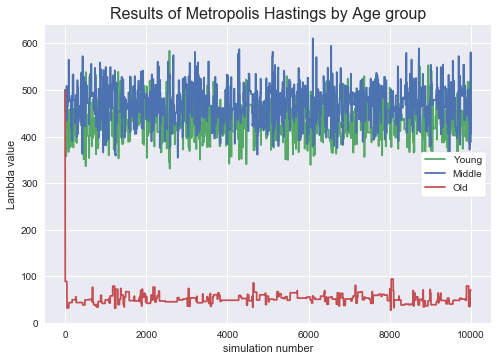

In [11]:
plt.plot(L_young, label = 'Young', color = 'C1')
plt.plot(L_middle, label = 'Middle', color = 'C0')
plt.plot(L_old, label = 'Old', color = 'C2')
plt.legend(facecolor='white', framealpha = 1, frameon = True, loc = 'right')
plt.ylabel('Lambda value')
plt.xlabel('simulation number')
plt.title('Results of Metropolis Hastings by Age group', fontsize=16)
plt.show()

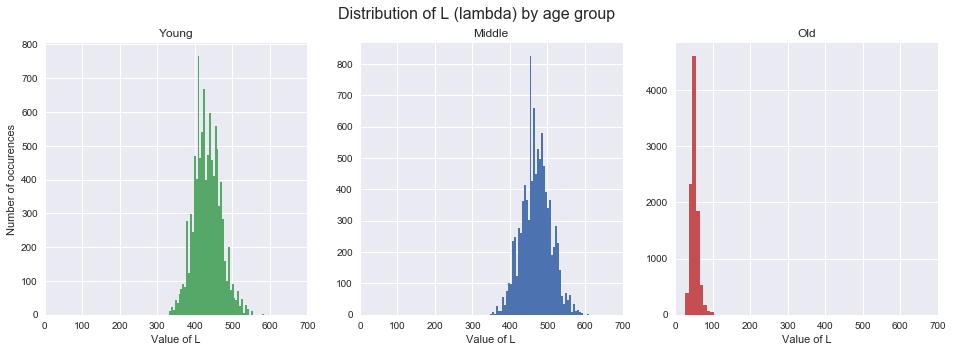

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(16,5))
fig.suptitle('Distribution of L (lambda) by age group', fontsize=16)

ax[0].hist(L_young, bins = 50, color = 'C1')
ax[0].set_xlim(0,700)
ax[0].set_xlabel('Value of L')
ax[0].set_ylabel('Number of occurences')
ax[0].set_title('Young')

ax[1].hist(L_middle, bins = 50, color = 'C0')
ax[1].set_xlim(0,700)
ax[1].set_xlabel('Value of L')
ax[1].set_title('Middle')

ax[2].hist(L_old, bins = 50, color = 'C2')
ax[2].set_xlim(0,700)
ax[2].set_xlabel('Value of L')
ax[2].set_title('Old')

plt.show()

In [13]:
#Without burn in 
print('Without burn in')
print('---------------')
print('L_young =', "%.0f" % np.mean(L_young))
print('L_middle =', "%.0f" % np.mean(L_middle))
print('L_old =', "%.1f" % np.mean(L_old))
print()

# With burn in 
print('With burn in')
print('---------------')
L_young = L_young[1000:10000]
L_middle  =  L_middle[1000:10000]
L_old = L_old[1000:10000]
print('L_young =', "%.0f" % np.mean(L_young))
print('L_middle =', "%.0f" % np.mean(L_middle))
print('L_old =', "%.1f" % np.mean(L_old))

Without burn in
---------------
L_young = 433
L_middle = 470
L_old = 51.9

With burn in
---------------
L_young = 433
L_middle = 469
L_old = 52.4


Young
---------
Empirical : a = 136.99  b = 0.00458
Gamma Fit : a = 151.99  b = 0.00285


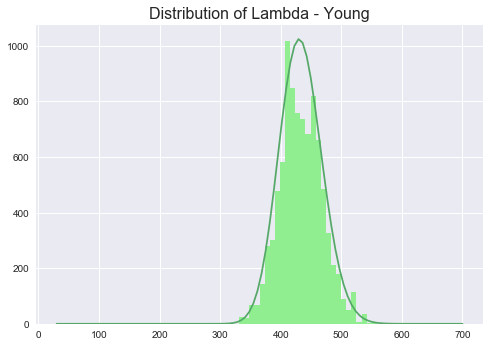

Middle
---------
Empirical: a = 146.80  b = 0.00472
Gamma Fit: a = 146.13  b = 0.00321


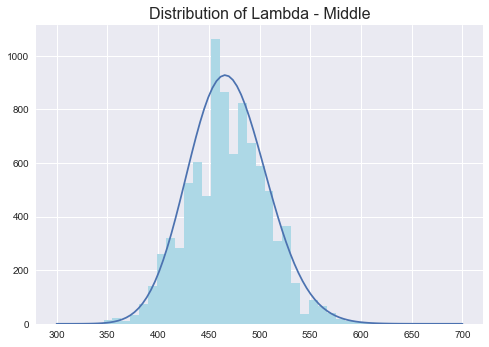

Old
---------
Empirical: a = 20.918  b = 0.00324
Gamma Fit: a = 31.37  b = 0.00167


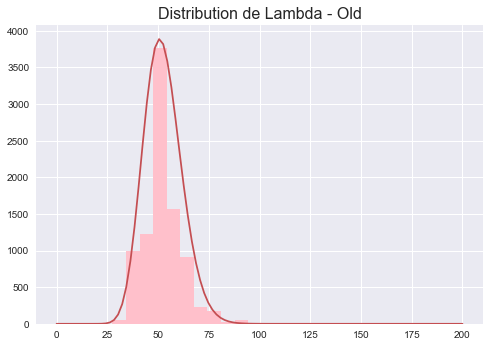

In [14]:
#Fit the posterior laws to gamma distribution

a_young_gfit , z, b_young_gfit = gamma.fit(L_young / 1000, floc = 0)
a_middle_gfit , z, b_middle_gfit = gamma.fit(L_middle / 1000, floc = 0)
a_old_gfit , z, b_old_gfit = gamma.fit(L_old / 1000, floc = 0)

print('Young')
print('---------')
print( 'Empirical : a =', "%.2f" % a_young, ' b =', "%.5f" %  b_young)
print( 'Gamma Fit : a =', "%.2f" % a_young_gfit, ' b =', "%.5f" %  b_young_gfit)

x = np.linspace(30,700,100)
y = gamma.pdf(x / 1000, a = a_young_gfit, scale = b_young_gfit) * L_young.shape[0] / 100
plt.plot(x,y, color = 'C1')
plt.hist(L_young, bins = 30, color = 'lightgreen')
plt.title('Distribution of Lambda - Young', fontsize = 16)
plt.show()

print('Middle')
print('---------')
print( 'Empirical: a =', "%.2f" %  a_middle, ' b =', "%.5f" %  b_middle)
print( 'Gamma Fit: a =', "%.2f" %  a_middle_gfit, ' b =', "%.5f" %  b_middle_gfit)
x = np.linspace(300,700,100)
y = gamma.pdf(x / 1000, a = a_middle_gfit, scale = b_middle_gfit) * L_middle.shape[0] / 100
plt.plot(x,y, color = 'C0')
plt.hist(L_middle, bins = 30, color = 'lightblue')
plt.title('Distribution of Lambda - Middle' , fontsize = 16)
plt.show()

print('Old')
print('---------')
print( 'Empirical: a =' , "%.3f" % a_old, ' b =', "%.5f" %  b_old)
print( 'Gamma Fit: a =', "%.2f" %  a_old_gfit, ' b =', "%.5f" %  b_old_gfit)
x = np.linspace(0,200,100)
y = gamma.pdf(x / 1000, a = a_old_gfit, scale = b_old_gfit) * L_old.shape[0] / 100 
plt.plot(x,y, color = 'C2')
plt.hist(L_old, bins = 10, color = 'pink')
plt.title('Distribution de Lambda - Old', fontsize = 16)
plt.show()

## 1.2 Relevance of a model by age groups  ?

In [15]:
# joint model for young and middle :  we get twice as much observations
# Theoretical values
#Young
young_middle = data[ ((data['Age']== '5 and younger') | (data['Age']== '5-59')) & (data['Year']<=2011) ].copy() # | for bitwise operations

mean_young_middle = np.mean( young_middle["N_victims"]/1000 )
var_young_middle = np.var( young_middle["N_victims"]/1000 )

a_emp_young_middle = mean_young_middle**2 / var_young_middle
b_emp_young_middle = var_young_middle / mean_young_middle

a_young_middle = a_emp_young_middle + sum(young_middle["N_victims"]/1000)
b_young_middle = 1 /(1 / b_emp_young_middle + 2 * n_train ) # twice as much observations because two classes
L_young_middle_emp = a_young_middle * b_young_middle * 1000


In [16]:
print(L_young_middle_emp)
print(L_young_emp)
print(L_middle_emp)

659.6850961538463
626.7980769230767
692.5721153846154


Let $M_0$ be the ‘Middle and Young separated’ model and $M_1$ the ‘Middle et Young combined’ model. 
We compute Bayes factor :

In [17]:
from scipy.special import gamma as gamma_euler

#preliminary variables to compute bayes factor as in the docx
sum_y_young = sum(df_young["N_victims"][0:n_train]/1000)
sum_y_middle = sum(df_middle["N_victims"][0:n_train]/1000)

#Bayes = ( gamma_euler(a_young +sum_y_young) * (n_train + 1/b_young)**(-a_young-sum_y_young) * 
         #gamma_euler(a_middle + sum_y_middle) * (n_train + 1/b_middle)**(-a_middle- sum_y_middle) *
                #gamma_euler(a) * b**a )/(  gamma_euler(a_young) * b_young**a_young * gamma_euler(a_middle) *b_middle**a_middle *
                   # gamma_euler(a + sum_y_young + sum_y_middle) * 
                    #(2*n_train + 1/b)**(-a - sum_y_young + sum_y_middle)  ) 

In [18]:
# Problème computationnel : en effet : 
gamma_euler(a_young)

3.4549215949997895e+232

In [19]:
# because of memory reasons, we can't compute Euler function of a two large float ,
# we therefore use BIC approximate with Laplace method 

# 2logBO1 ~ 2 log(f(y/teta0) / f(y/teta1)) - (p0-p1)log(n)
# B01  ~  exp( log(f(y/teta0) / f(y/teta1)) - 1/2*(p0-p1)log(n))
# avec teta0 et teta1 les EMV

# recall that lambda_young_EMV = mean_young
# recall that lambda_middle_EMV = mean_middle
p0 = 0.5
p1=0.5

mean_young_middle = (mean_young + mean_middle)/2  #same number of obs

log_Bayes_factor = np.log( (mean_young**sum_y_young * mean_middle**sum_y_middle * np.exp(-n_train*( mean_young+ mean_middle )) ) / 
                        ( mean_young_middle**(sum_y_young + sum_y_middle) * np.exp(-2*n_train*mean_young_middle) ) ) - 1/2*(p0 - p1)*np.log(2*n_train)

Bayes_factor_approx = np.exp(log_Bayes_factor)
Bayes_factor_approx



1.4065756387618462

Since the as the approximation of the Bayes factor is greater than 1, we keep $M_0$
it is 1.4 times more likely to be under the M0 model than the $M_1$ model. 

We keep separeted models by age group.

## 1.3 Predicted annual number of victims (with posteriors)

We're going to use the posterior to simulate the number of victims over the test period. 

In [20]:
# for each class, we compute 1000 times the ultimate number of victims and compare it to the true one:
sum_y_test_young = sum(df_young["N_victims"][n_train:])
sum_y_test_middle = sum(df_middle["N_victims"][n_train:])
sum_y_test_old = sum(df_old["N_victims"][n_train:])

n_weeks = n - n_train + 1 #total number of weeks for test set

def simu_victims(a, b, weeks):
    '''
    Input : 
        a, b : parameters of the gamma distribution followed by L / 1000 (the Poisson parameter)
        weeks : number of weeks
    Output : 
        Prediction of the number of victims during {weeks} weeks
    '''
    l = np.random.gamma(a, b, weeks) #generate lambdas 
    victims = 0 
    for i in range(0, weeks):
        victims += np.random.poisson(l[i]) * 1000 #add the victimes according to a poisson process lambda
                                                  #we multiply results by 
                                                  #1000 since we stored victims in thousands
    return(victims)

#Simulations : 
vec_test_young = []
vec_test_middle = []
vec_test_old = []
for i in range(0,10000) : 
    vec_test_young.append(simu_victims(a_young, b_young, n_weeks)) 
    vec_test_middle.append(simu_victims(a_middle, b_middle, n_weeks))
    vec_test_old.append(simu_victims(a_old, b_old, n_weeks))

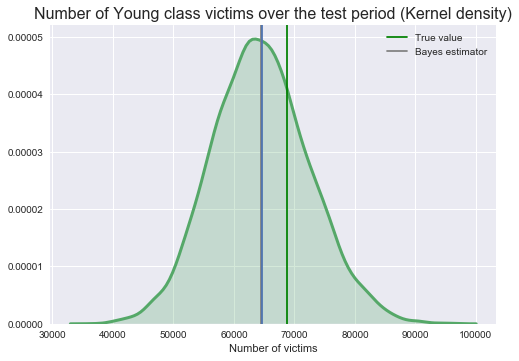

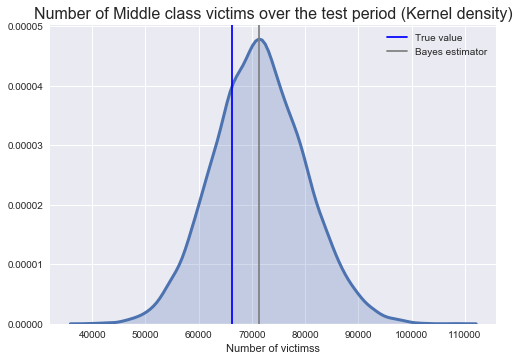

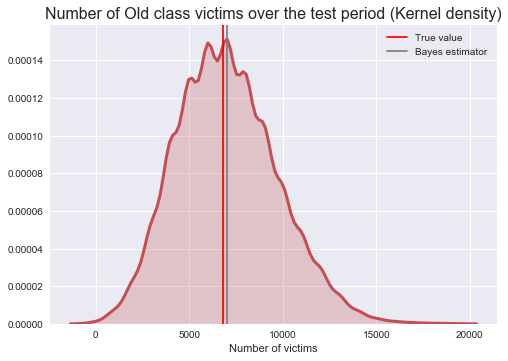

Erreur en % entre valeur prédite et valeur réelle
-------------------------------------------------
    Class        Real   Predicted   Error
0   Young 68,722.0000 64,451.2000 -6.2146
1  Middle 66,216.0000 71,382.9000  7.8031
2     Old  6,787.0000  7,008.3000  3.2606


In [21]:
#Kernel plot of young victims on test set victims
ax = sn.distplot( vec_test_young, hist = False, kde = True, color = 'C1', #kde = True for gaussian kernel density 
                 kde_kws = {'shade': True, 'linewidth': 3}, axlabel="Number of victims")
ax.set_title('Number of Young class victims over the test period (Kernel density)', size=16) 

plt.axvline(x = sum_y_test_young, color = 'green', label = 'True value')
plt.axvline(x = np.mean(vec_test_young), color = 'grey', label = 'Bayes estimator')
plt.axvline(x = n_weeks*L_young_emp  )
plt.legend()
plt.show()

#plt.savefig('young_predictions')


#kernel plot of middle victims on test set victims
ax = sn.distplot( vec_test_middle, hist = False, kde = True, color = 'C0', #gaussian kernel density 
                 kde_kws = {'shade': True, 'linewidth': 3}, axlabel="Number of victimss")
ax.set_title('Number of Middle class victims over the test period (Kernel density)', size=16) 


plt.axvline(x = sum_y_test_middle, color = 'blue', label = 'True value')
plt.axvline(x = np.mean(vec_test_middle), color = 'grey', label = 'Bayes estimator')
plt.legend()
plt.show()
#plt.savefig('middle_predictions')

#kernel plot of old victims on test set victims
ax = sn.distplot( vec_test_old, hist = False, kde = True, color = 'C2', #gaussian kernel density 
                 kde_kws = {'shade': True, 'linewidth': 3}, axlabel="Number of victims")
ax.set_title('Number of Old class victims over the test period (Kernel density)', size=16) 
plt.axvline(x = sum_y_test_old, color = 'red', label = 'True value')
plt.axvline(x = np.mean(vec_test_old), color = 'grey', label = 'Bayes estimator')
plt.legend()
plt.show()
#plt.savefig('old_predictions')



results = pd.DataFrame({'Class':['Young','Middle','Old'],
                        'Real':[sum_y_test_young * 1., sum_y_test_middle * 1., sum_y_test_old * 1.],
                        'Predicted':[np.mean(vec_test_young),np.mean(vec_test_middle),np.mean(vec_test_old)]})
results["Error"] = (results["Predicted"] - results["Real"]) / (results["Real"]) *100

print('Erreur en % entre valeur prédite et valeur réelle')
print('-------------------------------------------------')
print(results)



We are very satisfied with the Old class, the error being only about 2%.
For the young and old classes, the gap is greater but remains less than 8%.

The Bayesian method used could allow the Jamaican State to estimate the number of treatments needed for the next two years. 
Obviously, the best approach would be to use an epidemiological approach to estimate the number of people to be vaccinated to contain the virus, but the data presented here doesn't not allow this. 


If we reason in terms of the number of victims, then the "60+" age group seems to be much less impacted. The other two age groups have similar numbers of victims. 

However, we have to wait and see: the analysis we have just done concerns only the number of victims. A higher number of victims does not necessarily indicate a higher vulnerability. Indeed, one would have to look at the number of victims in relation to the total number of individuals in each class to get an idea of the vulnerability of each age group. 

In [22]:
jamaica = pd.read_csv('Jamaica-2012.csv')
print("Number of Jamaicans per age and sex")
print("-------------------------")
print(jamaica.head()) #we took data from 2012 to take a central asumption 
total = np.sum(jamaica.M) + np.sum(jamaica.F)

#hypothesis :  5 years old represent 1/5th of 5-9 class

total_young =  int(sum(np.sum(jamaica[jamaica["Age"] == '0-4'][['M','F']], axis=1) ,
                   1/5*np.sum(jamaica[jamaica["Age"] == '5-9'][['M','F']], axis=1))[1])

total_middle = int(sum( 4/5*np.sum(jamaica[jamaica["Age"] == '5-9'][['M','F']], axis=1), 
                   np.sum(np.sum(jamaica.iloc[2:11][['M','F']], axis=1))))
total_old = np.sum(np.sum(jamaica.iloc[12:][['M','F']], axis=1))

print("-------------------------")
print(pd.DataFrame({"Class" : ["young","middle","old"], "Nombre" : [total_young, total_middle, total_old]}))

Number of Jamaicans per age and sex
-------------------------
     Age       M       F
0    0-4  110818  107046
1    5-9  116789  112024
2  10-14  134843  128426
3  15-19  141080  135594
4  20-24  131680  126065
-------------------------
    Class   Nombre
0   young   263626
1  middle  2059061
2     old   327236


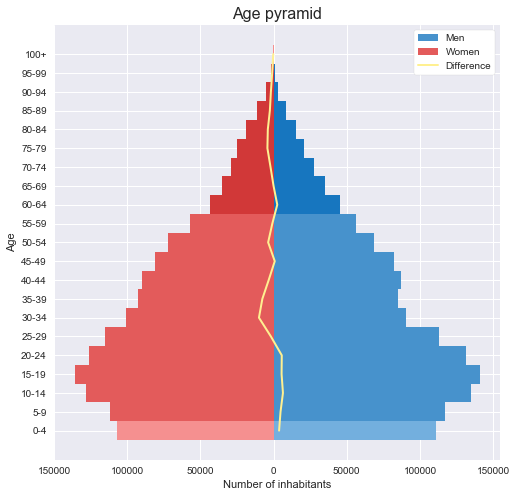

Color variations correspond to different age Class : Young, Middle, Old


In [23]:
jamaica['diff'] = jamaica['M'] - jamaica['F']
fig, ax = plt.subplots(figsize=(8,8))
colF = list(['#f59090' * 1]); colF.extend(['#e35b5b'] * 11); colF.extend(['#d13838'] * 8)
colH = list(['#73afde' * 1]); colH.extend(['#4792cc'] * 11); colH.extend(['#1776bf'] * 8)
ValF = ax.barh(np.arange(len(jamaica['F'])), -jamaica['F'], 1, label='Women', color=colF, linewidth=0, align='center')
ValH = ax.barh(np.arange(len(jamaica['M'])), jamaica['M'],1, label='Men', color=colH, linewidth=0, align='center')
diff, = ax.plot(jamaica['diff'],np.arange(len(jamaica['F'])),color='#fff091',linewidth=2)
ax.set_title('Age pyramid', fontsize = 16 )
ax.set_ylabel('Age')
ax.set_yticks(np.arange(len(jamaica['Age'])))
ax.set_yticklabels(jamaica['Age'])
ax.set_xlabel('Number of inhabitants')
ax.set_xticks(np.arange(-150000,150000+1,50000))
ax.set_xticklabels(abs(np.arange(-150000,150000+1,50000)))
ax.legend((ValH[1],ValF[1],diff),('Men','Women','Difference'),facecolor='white', framealpha = 1, frameon = True)
plt.show()
print('Color variations correspond to different age Class : Young, Middle, Old')

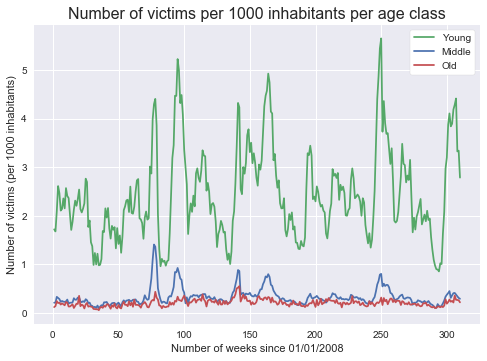

In [24]:
#For each age category, we create a new column with the percentage of the age category infected
x = np.linspace(1, n , n)

df_young['perc_vul'] = df_young['N_victims'] / total_young
df_middle['perc_vul'] = df_middle['N_victims'] / total_middle
df_old['perc_vul'] = df_old['N_victims'] / total_old

plt.plot(x, df_young['perc_vul'] * 1000,  color = 'C1', label = 'Young')
plt.plot(x, df_middle['perc_vul'] * 1000, color = 'C0', label = 'Middle')
plt.plot(x, df_old['perc_vul'] * 1000, color ='C2', label = 'Old')
plt.legend(frameon = True, facecolor = 'white', framealpha = 1)
plt.xlabel('Number of weeks since 01/01/2008')
plt.ylabel('Number of victims (per 1000 inhabitants)');
plt.title('Number of victims per 1000 inhabitants per age class', fontsize = 16)
plt.show()

The previous graph clearly shows that the age group 5 years and under is much more vulnerable to the symptoms of the epidemic. 
Curiously, the over-60s are slightly less impacted than the 5-59 year olds. 

## 2. Seasonal trend: Multinomial sampling a Dirichlet 

Consider the number of victims per year, and for each year calculate the weekly proportion of victims.

In [25]:
## Proportion hebdomadaire de victimes pour chaque classe d'age 
victims_per_year_young = df_young.groupby( ['Year'] , as_index=False)["N_victims"].sum()
victims_per_year_young.rename({'N_victims': 'Total_victims'}, axis=1, inplace=True)

victims_per_year_middle = df_middle.groupby( ['Year'] , as_index=False)["N_victims"].sum()
victims_per_year_middle.rename({'N_victims': 'Total_victims'}, axis=1, inplace=True)

victims_per_year_old = df_old.groupby( ['Year'] , as_index=False)["N_victims"].sum()
victims_per_year_old.rename({'N_victims': 'Total_victims'}, axis=1, inplace=True)

# Merge to add the total victims, then create the proportion column

df_young = df_young.merge(victims_per_year_young, on = 'Year')
df_middle = df_middle.merge(victims_per_year_middle, on = 'Year')
df_old = df_old.merge(victims_per_year_old, on = 'Year')

df_young["prop"] = df_young["N_victims"] / df_young["Total_victims"]
df_middle["prop"] = df_middle["N_victims"] / df_middle["Total_victims"]
df_old["prop"] = df_old["N_victims"] / df_old["Total_victims"]


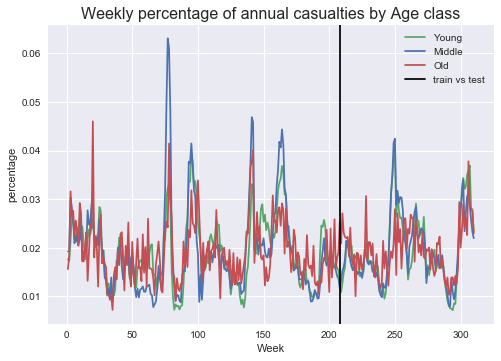

In [26]:
plt.plot(x, df_young['prop'], color='C1') 
plt.plot(x, df_middle['prop'], color='C0')
plt.plot(x, df_old['prop'], color='C2')
plt.axvline(x = n_train, color='black')
plt.legend(['Young', 'Middle', 'Old', 'train vs test'])
plt.title('Weekly percentage of annual casualties by Age class', fontsize = 16)
plt.xlabel('Week')
plt.ylabel('percentage')
plt.show()

We will use a multinomial sampling model coupled with a Dirichlet a priori to estimate the probability of a victim being sick in a given week. 

Once these a posteriori probabilities are estimated, we can use the simulation of the annual number of victims obtained in part 1 to spread it over each week. 

We will thus obtain a simulation of the counting process on a weekly basis. 

In [27]:
# prior : uniform weights
p_prior = np.repeat(1, 52)/52
rho_prior = np.repeat(2, 52)

In [28]:
# here, we also look the number of victims for each week 
# on the training sample, the number of victims for each class is : 
victims_per_week_young = df_young.loc[0:n_train].groupby( ['Week'] , as_index=False)["N_victims"].sum()
victims_per_week_young.rename({'N_victims': 'week_victims'}, axis=1, inplace=True)
victims_per_week_middle = df_middle.loc[0:n_train].groupby( ['Week'] , as_index=False)["N_victims"].sum()
victims_per_week_middle.rename({'N_victims': 'week_victims'}, axis=1, inplace=True)

victims_per_week_old = df_old.loc[0:n_train].groupby( ['Week'] , as_index=False)["N_victims"].sum()
victims_per_week_old.rename({'N_victims': 'week_victims'}, axis=1, inplace=True)

In [29]:
# compute posterior params of dirichlet law (conjugate law cf chap6 in the course)
young_rho_posterior = rho_prior + victims_per_week_young['week_victims']
middle_rho_posterior = rho_prior + victims_per_week_middle['week_victims']
old_rho_posterior = rho_prior + victims_per_week_old['week_victims']

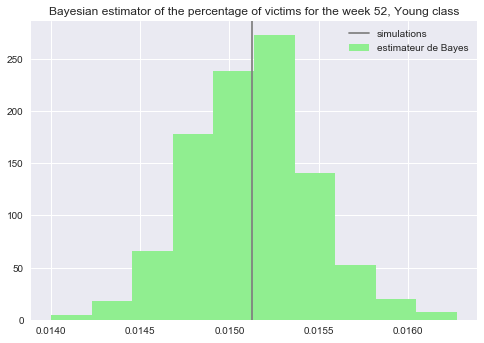

Value of the Bayes estimator : 0.015126982286054292


In [30]:
#plot posterior distribution of p52 for each class

young_p = pd.DataFrame(np.random.dirichlet(young_rho_posterior, 1000), columns = np.linspace(1,52,52))
plt.hist(young_p[52], color='lightgreen')
plt.axvline(x = np.mean(young_p[52]), color = 'grey', label = 'Bayesian estimator')
plt.title('Bayesian estimator of the percentage of victims for the week 52, Young class')
plt.legend(['simulations', 'estimateur de Bayes'])
plt.show()
print('Value of the Bayes estimator :' ,np.mean(young_p[52]))

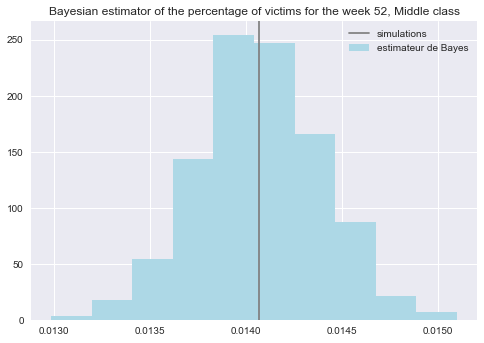

Value of the Bayes estimator : 0.014068719711459286


In [31]:
middle_p = pd.DataFrame(np.random.dirichlet(middle_rho_posterior, 1000), columns = np.linspace(1,52,52))
plt.hist(middle_p[52], color='lightblue')
plt.axvline(x = np.mean(middle_p[52]), color = 'grey', label = 'Bayesian estimator')
plt.title('Bayesian estimator of the percentage of victims for the week 52, Middle class')
plt.legend(['simulations', 'estimateur de Bayes'])
plt.show()
print('Value of the Bayes estimator :' , np.mean(middle_p[52]))

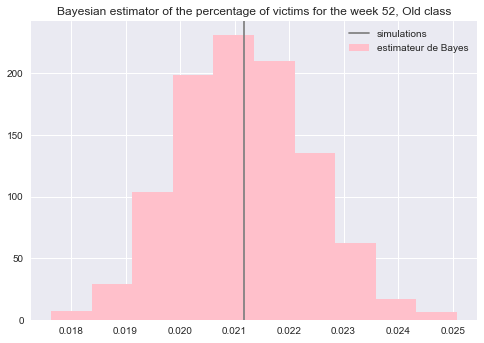

Value of the Bayes estimator : 0.021177111564435965


In [32]:
old_p = pd.DataFrame(np.random.dirichlet(old_rho_posterior, 1000), columns = np.linspace(1,52,52))
plt.hist(old_p[52], color='pink') #plot for the 52th week of the year
plt.axvline(x = np.mean(old_p[52]), color = 'grey', label = 'Bayesian estimator')
plt.title('Bayesian estimator of the percentage of victims for the week 52, Old class')
plt.legend(['simulations', 'estimateur de Bayes'])
plt.show()
print('Value of the Bayes estimator :' , np.mean(old_p[52]))

# STOP HERE 

Let us check if we caught the seasonality : for each year, we look at the total number of victims and we split it according the posterior mean proportion.

In [33]:
print(young_p.shape)
victims_per_year_young['Total_victims'][:7]

def get1_simu(total_col, weights_p) : 
    simu = []
    for i in range(0,len(total_col)) :
        simu.append(np.random.multinomial(total_col[i] , weights_p , size=1)) 
    return (np.concatenate(np.concatenate(simu)))


# we have simulated 100 vectors of p, for each vector we simulate 100 realization of multinomial sampling
test = get1_simu(victims_per_year_young['Total_victims'][:7], np.asarray(young_p.loc[1,]))

young_repartition = []
middle_repartition = []
old_repartition = []


for i in range(0,1000):
    young_repartition.append(get1_simu(victims_per_year_young['Total_victims'][:7], np.asarray(young_p.loc[i,])))
    middle_repartition.append(get1_simu(victims_per_year_middle['Total_victims'][:7], np.asarray(middle_p.loc[i,])))
    old_repartition.append(get1_simu(victims_per_year_old['Total_victims'][:7], np.asarray(old_p.loc[i,])))



    

(1000, 52)


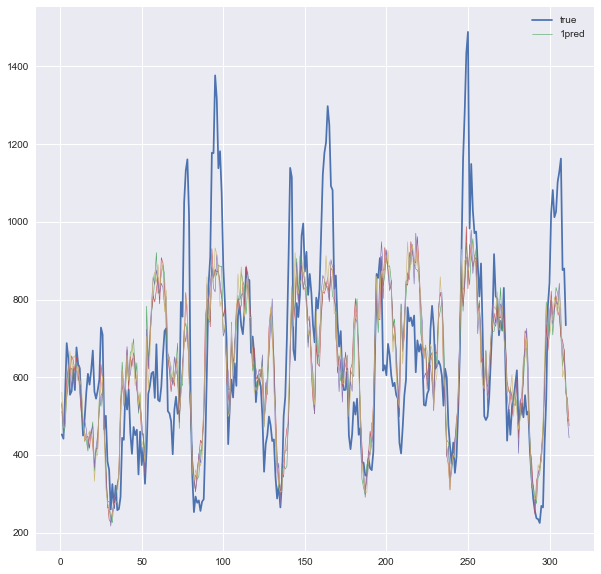

In [34]:
plt.figure(figsize=(10, 10))
x = np.linspace(1,52*6,52*6 )

plt.plot(x, df_young['N_victims'][:52*6].append(pd.Series([float('NaN'), float('NaN')])) )  #on rajoute les deux dernières semaines manquantes
plt.plot(x , young_repartition[1], linewidth = 0.6)
plt.plot(x , young_repartition[2], linewidth = 0.6)
plt.plot(x , young_repartition[4], linewidth = 0.6)
plt.plot(x , young_repartition[14], linewidth = 0.6)

plt.legend(['true', '1pred'])

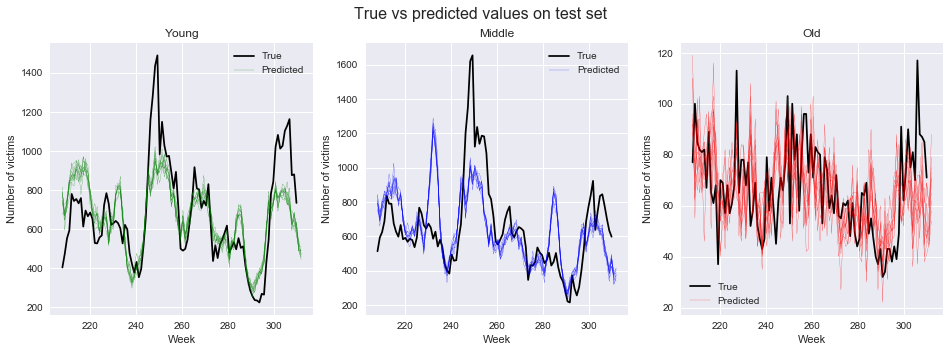

In [35]:
#plot on test only 

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,5))
fig.suptitle('True vs predicted values on test set ', fontsize=16)

x = np.linspace(52*4, 52*6, 52*2 )

ax[0].plot(x, df_young['N_victims'][4*52:52*6].append(pd.Series([float('NaN'), float('NaN')])) , color='black')
ax[1].plot(x, df_middle['N_victims'][4*52:52*6].append(pd.Series([float('NaN'), float('NaN')])), color='black')
ax[2].plot(x, df_old['N_victims'][4*52:52*6].append(pd.Series([float('NaN'), float('NaN')])), color='black')


for s in range(0,10):
    ax[0].plot(x , young_repartition[s][4*52:52*6], linewidth = 0.2, color='green')
    ax[1].plot( x,  middle_repartition[s][4*52:52*6], linewidth = 0.2, color='blue')
    ax[2].plot( x,  old_repartition[s][4*52:52*6], linewidth = 0.2, color='red')

ax[0].set_title('Young')
ax[1].set_title('Middle')
ax[2].set_title('Old')

ax[0].set_ylabel('Number of victims')
ax[1].set_ylabel('Number of victims')
ax[2].set_ylabel('Number of victims')

ax[0].set_xlabel('Week')
ax[1].set_xlabel('Week')
ax[2].set_xlabel('Week')

ax[0].legend(['True', 'Predicted'])
ax[1].legend(['True', 'Predicted'])
ax[2].legend(['True', 'Predicted'])




plt.show()

In [36]:
# metric for results

mse_young = []
mse_middle = []
mse_old = []

for s in range(0,1000):
    mse_young.append(mse(df_young['N_victims'][4*52:(52*6-2)], young_repartition[s][4*52:(52*6-2)] ))
    mse_middle.append(mse(df_middle['N_victims'][4*52:(52*6-2)], middle_repartition[s][4*52:(52*6-2)] ))
    mse_old.append(mse(df_old['N_victims'][4*52:(52*6-2)], old_repartition[s][4*52:(52*6-2)] ))



print('rmse young:' ,np.mean(mse_young)**0.5 )
print('rmse middle : ' , np.mean(mse_middle)**0.5 ) 
print('rmse old : ', np.mean(mse_old)**0.5 ) 



rmse young: 176.18234521286712
rmse middle :  219.87644578663878
rmse old :  19.953978668573402


In [37]:
from sklearn.metrics import mean_absolute_error as mae


mse_young = []
mse_middle = []
mse_old = []

for s in range(0,1000):
    mse_young.append(mae(df_young['N_victims'][4*52:(52*6-2)], young_repartition[s][4*52:(52*6-2)] ))
    mse_middle.append(mae(df_middle['N_victims'][4*52:(52*6-2)], middle_repartition[s][4*52:(52*6-2)] ))
    mse_old.append(mae(df_old['N_victims'][4*52:(52*6-2)], old_repartition[s][4*52:(52*6-2)] ))



print('mae young:' , np.mean(mse_young) )
print('mae middle : ' , np.mean(mse_middle) ) 
print('mae old : ', np.mean(mse_old) ) 




mae young: 134.8356862745098
mae middle :  160.53103921568626
mae old :  15.621323529411766


MAE > RMSE : indicates the existence of large errors. 

## Combination of models 1 and 2

Our second approach to combine the models is the following :
* we simulate the number of victims
* we simulate the monthly proportion
* we draw a large number of paths
* we look at the average path

In [38]:
victims_simu_young = []
victims_simu_middle = []
victims_simu_old = []

for i in range(0,6*1000) : 
    victims_simu_young.append(simu_victims(a_young,b_young, 52))
    victims_simu_middle.append(simu_victims(a_middle,b_middle, 52))
    victims_simu_old.append(simu_victims(a_old,b_old, 52))

compound_model = { 'Young' : [] , 'Middle' : [], 'Old' : []}
for i in range(0,1000):
    compound_model['Young'].append(get1_simu(victims_simu_young[6*i:6*(i+1)], np.asarray(young_p.loc[i,])))
    compound_model['Middle'].append(get1_simu(victims_simu_middle[6*i:6*(i+1)], np.asarray(middle_p.loc[i,])))
    compound_model['Old'].append(get1_simu(victims_simu_old[6*i:6*(i+1)], np.asarray(old_p.loc[i,])))



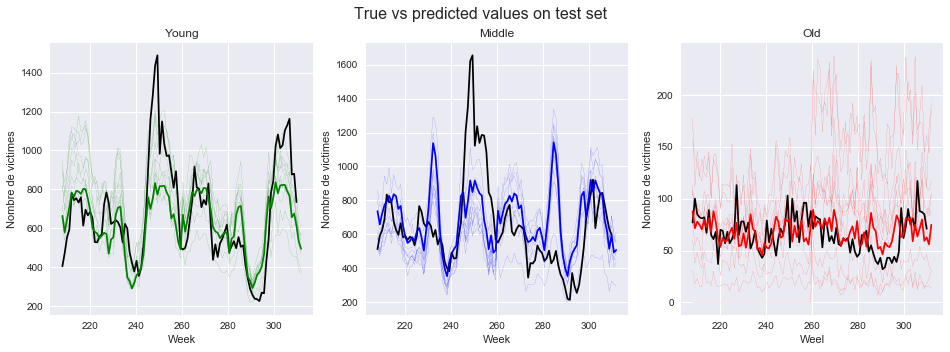

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(16,5))
fig.suptitle('True vs predicted values on test set ', fontsize=16)

x = np.linspace(52*4, 52*6, 52*2 )

ax[0].plot(x, df_young['N_victims'][4*52:52*6].append(pd.Series([float('NaN'), float('NaN')])), color='black')
ax[1].plot(x, df_middle['N_victims'][4*52:52*6].append(pd.Series([float('NaN'), float('NaN')])), color='black')
ax[2].plot(x, df_old['N_victims'][4*52:52*6].append(pd.Series([float('NaN'), float('NaN')])), color='black')




for s in np.random.choice(range(0,1000), 10):
    ax[0].plot(x , compound_model['Young'][s][4*52:52*6], linewidth = 0.1, color='green')
    ax[1].plot( x ,  compound_model['Middle'][s][4*52:52*6], linewidth = 0.1, color='blue')
    ax[2].plot( x ,  compound_model['Old'][s][4*52:52*6], linewidth = 0.1, color='red')


#plot mean trajectory in bold
young_mean_traj = pd.DataFrame(compound_model['Young']).apply(np.mean, axis=0)[4*52:52*6]
middle_mean_traj = pd.DataFrame(compound_model['Middle']).apply(np.mean, axis=0)[4*52:52*6]
old_mean_traj = pd.DataFrame(compound_model['Old']).apply(np.mean, axis=0)[4*52:52*6]



ax[0].plot( x ,young_mean_traj , color='green')
ax[1].plot( x, middle_mean_traj , color='blue')
ax[2].plot( x, old_mean_traj , color='red')

ax[0].set_title('Young')
ax[1].set_title('Middle')
ax[2].set_title('Old')

ax[0].set_ylabel('Nombre de victimes')
ax[1].set_ylabel('Nombre de victimes')
ax[2].set_ylabel('Nombre de victimes')

ax[0].set_xlabel('Week')
ax[1].set_xlabel('Week')
ax[2].set_xlabel('Weel')

plt.show()

In [40]:
# Computation of errors removing the 2 last missing data


print('RMSE on the average path')
print('---------------------------')
print('average error young : ' , np.mean(mse(df_young['N_victims'][4*52:(52*6-2)] , young_mean_traj[:-2]))**0.5 ) 
print('average error middle : ' , np.mean(mse(df_middle['N_victims'][4*52:(52*6-2)], middle_mean_traj[:-2]))**0.5 ) 
print('average error old : ' , np.mean(mse(df_old['N_victims'][4*52:(52*6-2)] , old_mean_traj[:-2]))**0.5 ) 
print()

print('RMSE on the constant estimator equal to the mean')
print('----------------------------------------------')
print('average error young : ' , np.mean(mse(df_young['N_victims'][4*52:(52*6-2)] , np.repeat(np.mean(df_young['N_victims'][4*52:(52*6-2)]), (52*2-2) )))**0.5 ) 
print('average error middle : ' , np.mean(mse(df_middle['N_victims'][4*52:(52*6-2)], np.repeat(np.mean(df_middle['N_victims'][4*52:(52*6-2)]), (52*2-2) )))**0.5 ) 
print('average error old : ' , np.mean(mse(df_old['N_victims'][4*52:(52*6-2)] , np.repeat(np.mean(df_old['N_victims'][4*52:(52*6-2)]), (52*2-2) )))**0.5 ) 
print()

print('MAE on the average path')
print('---------------------------')
print('average error young : ' , np.mean(mae(df_young['N_victims'][4*52:(52*6-2)] , young_mean_traj[:-2])) ) 
print('average error middle : ' , np.mean(mae(df_middle['N_victims'][4*52:(52*6-2)], middle_mean_traj[:-2])) ) 
print('average error old : ' , np.mean(mae(df_old['N_victims'][4*52:(52*6-2)] , old_mean_traj[:-2])) ) 
print()
print('Average error (%)')
print('---------------------------')
print('average error young % : ' , np.mean(abs((df_young['N_victims'][4*52:(52*6-2)] - young_mean_traj[:-2])/df_young['N_victims'][4*52:(52*6-2)]))* 100) 
print('average error middle % : ' , np.mean(abs((df_middle['N_victims'][4*52:(52*6-2)] - middle_mean_traj[:-2])/df_middle['N_victims'][4*52:(52*6-2)]))* 100)
print('average error old % : ' , np.mean(abs((df_old['N_victims'][4*52:(52*6-2)] - old_mean_traj[:-2])/df_old['N_victims'][4*52:(52*6-2)]))* 100)


RMSE on the average path
---------------------------
average error young :  184.2446454897592
average error middle :  250.8971337271903
average error old :  18.57425110516295

RMSE on the constant estimator equal to the mean
----------------------------------------------
average error young :  258.02062108936826
average error middle :  262.1979648656719
average error old :  17.729266581065872

MAE on the average path
---------------------------
average error young :  134.04313725490195
average error middle :  181.15559803921565
average error old :  14.653666666666668

Average error (%)
---------------------------
average error young % :  19.817659808850276
average error middle % :  31.180880979444282
average error old % :  24.15099896703959


## Criticism of our approach : 
We estimated the seasonality thanks to our multinomial sampling coupled with a dirichlet a priori. Even if this seasonality is well estimated, the precision of the simulations depends strongly on the precision of the total number of victims over the year which could be subject to a particular trend (drift).  

This seasonality may vary over time. If the near past is judged to have more influence than the distant past on future values, then a more classical approach would be a time series approach (ARIMA) to take into account a drift in addition to seasonality. 

Our method could take this drift into account by re-estimating the law a posteriori each year over a sliding period. Thus, the posteriori distribution coefficients of our counting process would depend on a moving average of the observations. 
Similarly, to take into account a change in seasonality, we could use the estimation of the posterior distribution over a sliding period. 



# 3. SARIMA

Now, let's see what results we would get with a frequentist approach.

In [41]:
result = adfuller(df_young['N_victims'][:n_train])
print('-------------------------------')
print('Young')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

result = adfuller(df_middle['N_victims'][:n_train])
print('-------------------------------')
print('Middle')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

result = adfuller(df_old['N_victims'][:n_train])
print('-------------------------------')
print('Old')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

#p-value < 0.05 => We cannot reject the stationary hypothesis 

-------------------------------
Young
ADF Statistic: -4.544798
p-value: 0.000163
-------------------------------
Middle
ADF Statistic: -5.419200
p-value: 0.000003
-------------------------------
Old
ADF Statistic: -4.519493
p-value: 0.000181


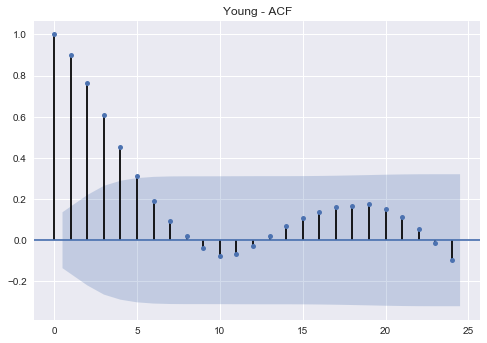

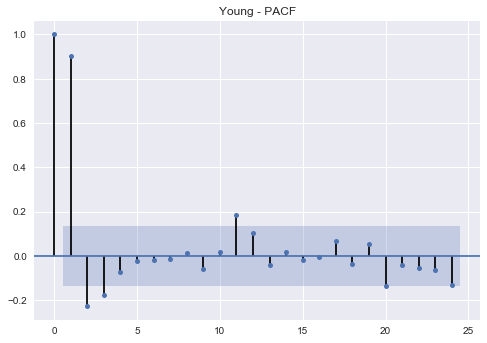

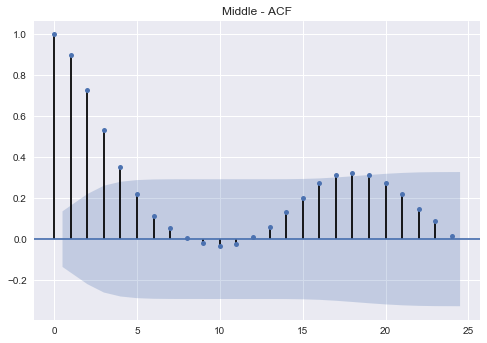

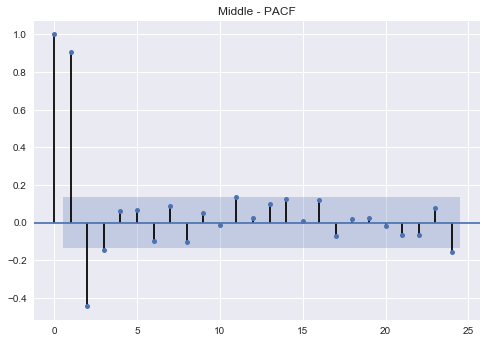

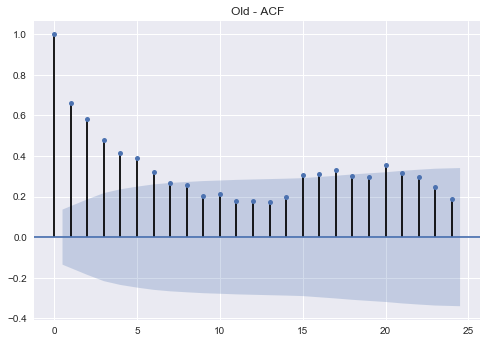

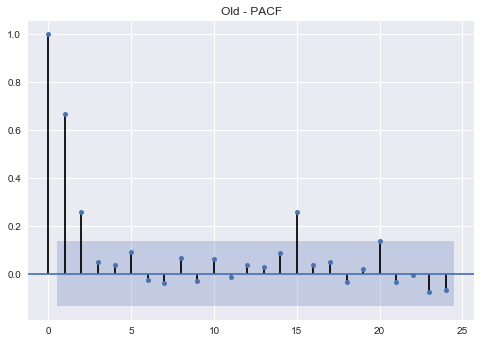

In [42]:
plot_acf(df_young['N_victims'][:n_train], title = 'Young - ACF')
plot_pacf(df_young['N_victims'][:n_train], title = 'Young - PACF')

plot_acf(df_middle['N_victims'][:n_train], title = 'Middle - ACF')
plot_pacf(df_middle['N_victims'][:n_train], title = 'Middle - PACF')

plot_acf(df_old['N_victims'][:n_train], title = 'Old - ACF')
plot_pacf(df_old['N_victims'][:n_train], title = 'Old - PACF');

## 3.1 Young

In [43]:
#CAREFUL : THE COMPUTING TIME IS HIGH (about 10 minutes)
df = df_young['N_victims'][:n_train]

arima_model_young = pm.auto_arima(df, 
                      start_p=0, 
                      start_q=2,
                      test='adf',        
                      max_p=3, max_q=3,  # maximum p and q
                      m=52,              # Our data is divided in weeks
                      d=0,                
                      seasonal=True,     
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True, 
                      stepwise=True)

print(arima_model_young.summary())

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 2)x(0, 1, 1, 52) (constant=True); AIC=2016.706, BIC=2031.955, Time=43.995 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 52) (constant=True); AIC=2218.818, BIC=2224.917, Time=0.279 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 52) (constant=True); AIC=1975.010, BIC=1987.210, Time=16.317 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 52) (constant=True); AIC=2066.029, BIC=2078.228, Time=37.348 seconds
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 52) (constant=False); AIC=2223.536, BIC=2226.585, Time=0.263 seconds
Fit ARIMA: (1, 0, 0)x(0, 1, 0, 52) (constant=True); AIC=2009.929, BIC=2019.079, Time=1.981 seconds
Fit ARIMA: (1, 0, 0)x(2, 1, 0, 52) (constant=True); AIC=1949.830, BIC=1965.079, Time=122.577 seconds
Near non-invertible roots for order (1, 0, 0)(2, 1, 0, 52); setting score to inf (at least one inve

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9752      0.091     10.679      0.000       0.796       1.154
ar.L2          0.0814      0.113      0.724      0.469      -0.139       0.302
ar.L3         -0.1461      0.080     -1.823      0.068      -0.303       0.011
ar.S.L52      -0.8001      0.099     -8.116      0.000      -0.993      -0.607
ar.S.L104     -0.6680      0.072     -9.238      0.000      -0.810      -0.526
sigma2      9034.1114   1461.468      6.182      0.000    6169.687    1.19e+04


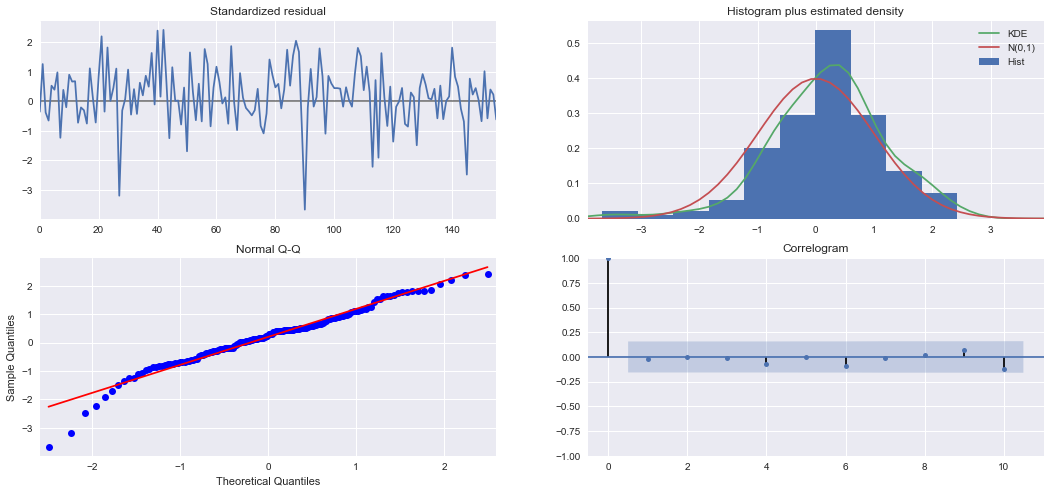

In [44]:
model_young = SARIMAX(df_young['N_victims'][0:n_train], order=(3,0,0),  seasonal_order=(2,1,0,52))
model_young_fit = model_young.fit()
print(model_young_fit.summary().tables[1])
model_young_fit.plot_diagnostics(figsize=(18, 8))
plt.show()

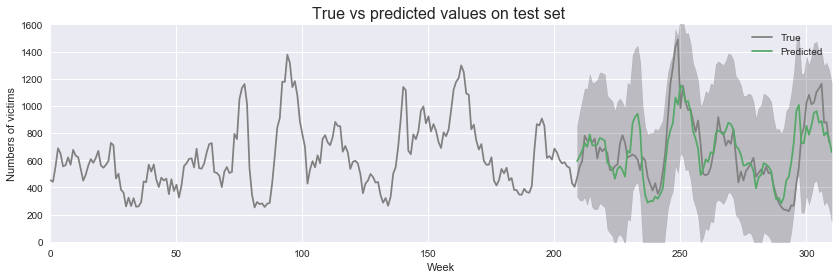

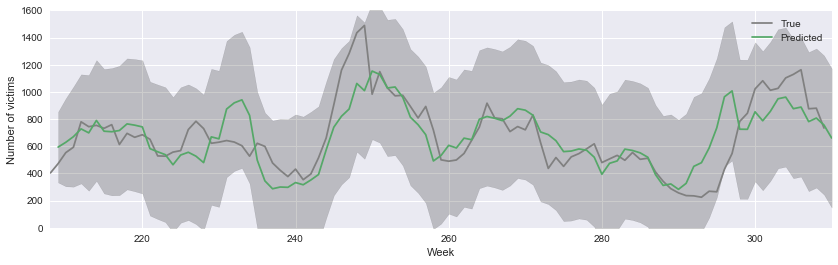

In [45]:
pred = model_young_fit.get_prediction(start=n_train+1, end = n, dynamic=False)
pred_young = pred.predicted_mean
pred_ci = pred.conf_int()
ax = df_young['N_victims'].plot(label='True', color='grey')

pred.predicted_mean.plot(ax=ax, label='Predicted', figsize=(14, 4), color = 'C1')
ax.set_ylim(0,1600)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Week')
ax.set_ylabel('Numbers of victims')
plt.legend()
plt.title('True vs predicted values on test set ', fontsize=16)
plt.show()

pred = model_young_fit.get_prediction(start=n_train+1, end = n, dynamic=False)
pred_ci = pred.conf_int()
ax = df_young['N_victims'][n_train:].plot(label='True', color='grey')

pred.predicted_mean.plot(ax=ax, label='Predicted', figsize=(14, 4), color = 'C1')
ax.set_ylim(0,1600)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Week')
ax.set_ylabel('Number of victims')
plt.legend()
plt.show()

## 3.2 Middle

In [46]:
#CAREFUL : THE COMPUTING TIME IS HIGH (about 20 minutes)
df = df_middle['N_victims'][:n_train]

arima_model_middle = pm.auto_arima(df, 
                      start_p=0, 
                      start_q=2,
                      test='adf',        
                      max_p=3, max_q=3,  # maximum p and q
                      m=52,              # Our data is divided in weeks
                      d=0,                
                      seasonal=True,
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True, 
                      stepwise=True)

print(arima_model_middle.summary())

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 2)x(0, 1, 1, 52) (constant=True); AIC=2193.894, BIC=2209.143, Time=39.570 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 52) (constant=True); AIC=2471.302, BIC=2477.402, Time=0.275 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 52) (constant=True); AIC=2163.166, BIC=2175.366, Time=30.374 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 52) (constant=True); AIC=2266.105, BIC=2278.304, Time=31.333 seconds
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 52) (constant=False); AIC=2472.408, BIC=2475.458, Time=0.340 seconds
Fit ARIMA: (1, 0, 0)x(0, 1, 0, 52) (constant=True); AIC=2208.254, BIC=2217.404, Time=1.693 seconds
Fit ARIMA: (1, 0, 0)x(2, 1, 0, 52) (constant=True); AIC=2103.735, BIC=2118.984, Time=169.963 seconds
Near non-invertible roots for order (1, 0, 0)(2, 1, 0, 52); setting score to inf (at least one inve

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2042      0.074     16.315      0.000       1.060       1.349
ar.L2         -0.0851      0.136     -0.627      0.531      -0.351       0.181
ar.L3         -0.1815      0.102     -1.777      0.076      -0.382       0.019
ar.S.L52      -0.8906      0.080    -11.080      0.000      -1.048      -0.733
ar.S.L104     -0.8475      0.032    -26.225      0.000      -0.911      -0.784
sigma2      1.495e+04   2752.277      5.433      0.000    9558.975    2.03e+04


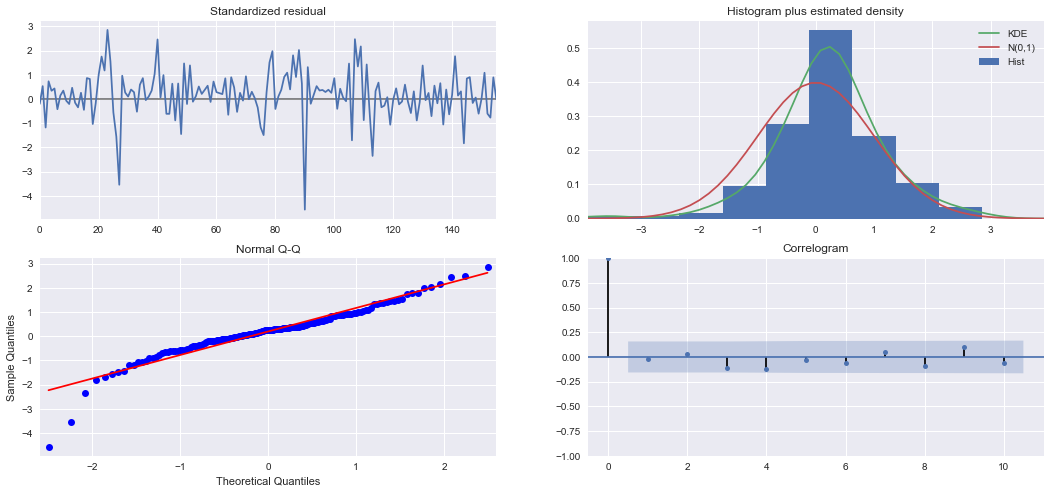

In [47]:
model_middle = SARIMAX(df_middle['N_victims'][0:n_train], order=(3,0,0),  seasonal_order=(2,1,0,52))
model_middle_fit = model_middle.fit()
print(model_middle_fit.summary().tables[1])
model_middle_fit.plot_diagnostics(figsize=(18, 8))
plt.show()

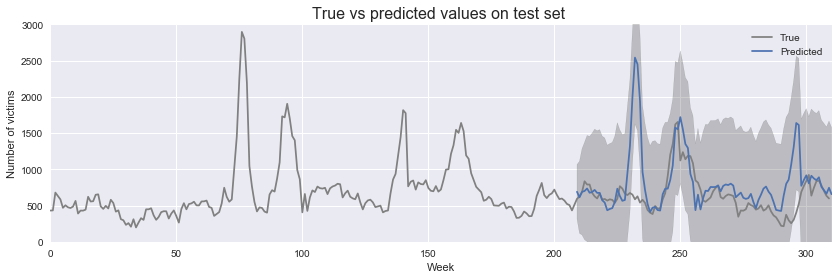

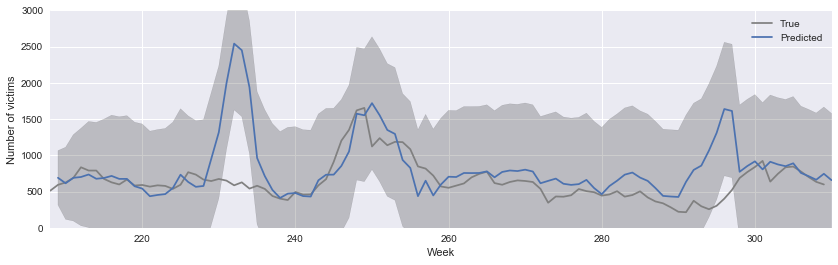

In [48]:
pred = model_middle_fit.get_prediction(start=n_train+1, end = n, dynamic=False)
pred_middle = pred.predicted_mean
pred_ci = pred.conf_int()
ax = df_middle['N_victims'].plot(label='True', color = 'grey')

pred.predicted_mean.plot(ax=ax, label='Predicted', figsize=(14, 4), color = 'C0')
ax.set_ylim(0,3000)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Week')
ax.set_ylabel('Number of victims')
plt.legend()
plt.title('True vs predicted values on test set ', fontsize=16)
plt.show()

pred = model_middle_fit.get_prediction(start=n_train+1, end = n, dynamic=False)
pred_ci = pred.conf_int()
ax = df_middle['N_victims'][n_train:].plot(label='True', color = 'grey')

pred.predicted_mean.plot(ax=ax, label='Predicted', figsize=(14, 4), color = 'C0')
ax.set_ylim(0,3000)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Week')
ax.set_ylabel('Number of victims')
plt.legend()
plt.show()

## 3.3 Old

In [49]:
df = df_old['N_victims'][:n_train]

arima_model_old = pm.auto_arima(df, 
                      start_p=0, 
                      start_q=2,
                      test='adf',        
                      max_p=3, max_q=3,  # maximum p and q
                      m=52,              # Our data is divided in weeks
                      d=0,                
                      seasonal=True,     
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True, 
                      stepwise=True)

print(arima_model_old.summary())

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 2)x(0, 1, 1, 52) (constant=True); AIC=1450.683, BIC=1465.932, Time=33.341 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 52) (constant=True); AIC=1584.300, BIC=1590.400, Time=0.268 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 52) (constant=True); AIC=1453.471, BIC=1465.670, Time=12.139 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 52) (constant=True); AIC=1476.275, BIC=1488.475, Time=24.312 seconds
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 52) (constant=False); AIC=1588.192, BIC=1591.242, Time=0.263 seconds
Fit ARIMA: (0, 0, 2)x(0, 1, 0, 52) (constant=True); AIC=1499.736, BIC=1511.936, Time=4.245 seconds
Fit ARIMA: (0, 0, 2)x(1, 1, 1, 52) (constant=True); AIC=1450.530, BIC=1468.829, Time=30.810 seconds
Near non-invertible roots for order (0, 0, 2)(1, 1, 1, 52); setting score to inf (at least one inver

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5101      0.081      6.266      0.000       0.351       0.670
ar.L2          0.3144      0.093      3.373      0.001       0.132       0.497
ar.S.L52      -0.8747      0.107     -8.213      0.000      -1.083      -0.666
ar.S.L104     -0.5132      0.104     -4.953      0.000      -0.716      -0.310
sigma2       361.6823     55.324      6.538      0.000     253.249     470.115


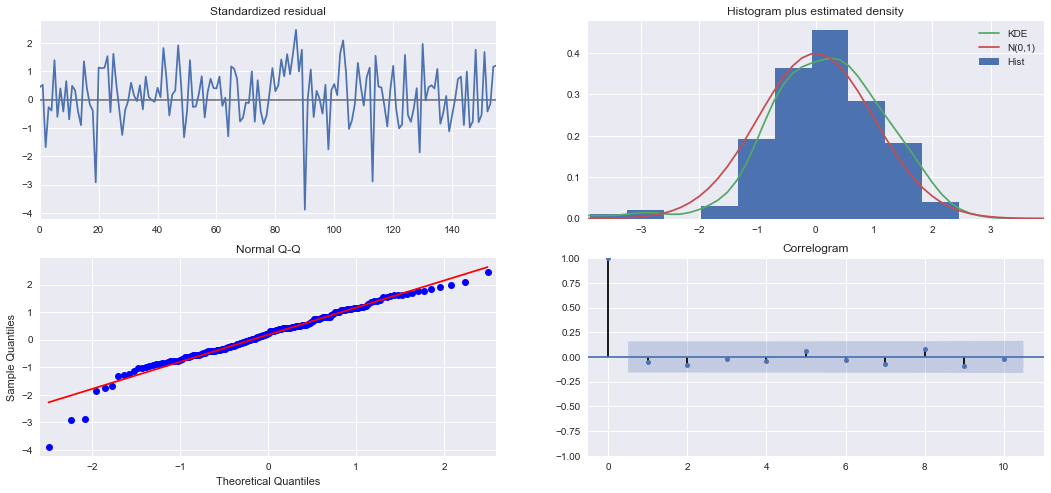

In [50]:
model_old = SARIMAX(df_old['N_victims'][0:n_train], order=(2,0,0),  seasonal_order=(2,1,0,52))
model_old_fit = model_old.fit()
print(model_old_fit.summary().tables[1])
model_old_fit.plot_diagnostics(figsize=(18, 8))
plt.show()

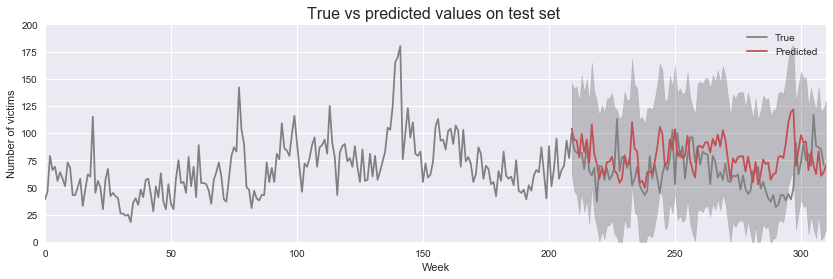

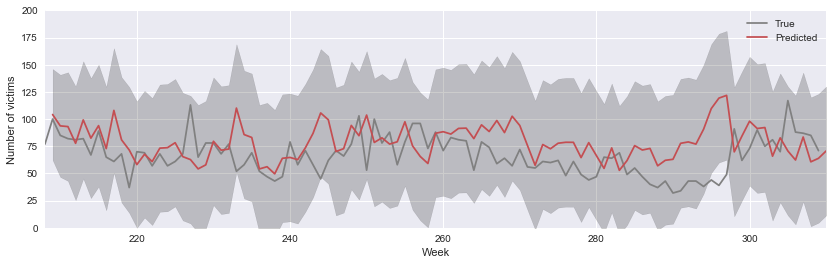

In [51]:
pred = model_old_fit.get_prediction(start=n_train+1, end = n, dynamic=False)
pred_old = pred.predicted_mean
pred_ci = pred.conf_int()
ax = df_old['N_victims'].plot(label='True', color = 'grey')

pred.predicted_mean.plot(ax=ax, label='Predicted', figsize=(14, 4), color = 'C2')
ax.set_ylim(0,200)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Week')
ax.set_ylabel('Number of victims')
plt.title('True vs predicted values on test set ', fontsize=16)
plt.legend()
plt.show()

pred = model_old_fit.get_prediction(start=n_train+1, end = n, dynamic=False)
pred_ci = pred.conf_int()
ax = df_old['N_victims'][n_train:].plot(label='True', color = 'grey')

pred.predicted_mean.plot(ax=ax, label='Predicted', figsize=(14, 4), color = 'C2')
ax.set_ylim(0,200)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Week')
ax.set_ylabel('Number of victims')
plt.legend()
plt.show()

In [52]:
# Computation of errors removing the 2 last missing data

print('RMSE on the predicted path')
print('---------------------------')
print('average error young : ' , np.mean(mse(df_young['N_victims'][4*52:(52*6-2)] , pred_young))**0.5 ) 
print('average error middle : ' , np.mean(mse(df_middle['N_victims'][4*52:(52*6-2)], pred_middle))**0.5 ) 
print('average error old : ' , np.mean(mse(df_old['N_victims'][4*52:(52*6-2)] , pred_old))**0.5 ) 
print()

print('RMSE on the constant estimator equal to the mean')
print('----------------------------------------------')
print('average error young : ' , np.mean(mse(df_young['N_victims'][4*52:(52*6-2)] , np.repeat(np.mean(df_young['N_victims'][4*52:(52*6-2)]), (52*2-2) )))**0.5 ) 
print('average error middle : ' , np.mean(mse(df_middle['N_victims'][4*52:(52*6-2)], np.repeat(np.mean(df_middle['N_victims'][4*52:(52*6-2)]), (52*2-2) )))**0.5 ) 
print('average error old : ' , np.mean(mse(df_old['N_victims'][4*52:(52*6-2)] , np.repeat(np.mean(df_old['N_victims'][4*52:(52*6-2)]), (52*2-2) )))**0.5 ) 
print()

print('MAE on the predicted path')
print('---------------------------')
print('average error young : ' , np.mean(mae(df_young['N_victims'][4*52:(52*6-2)] , pred_young)) ) 
print('average error middle : ' , np.mean(mae(df_middle['N_victims'][4*52:(52*6-2)], pred_middle)) ) 
print('average error old : ' , np.mean(mae(df_old['N_victims'][4*52:(52*6-2)] , pred_old)) ) 
print()
print('Average error (%)')
print('---------------------------')
print('average error young % : ' , np.mean(abs((df_young['N_victims'][4*52:(52*6-2)] - pred_young)/df_young['N_victims'][4*52:(52*6-2)]))* 100) 
print('average error middle % : ' , np.mean(abs((df_middle['N_victims'][4*52:(52*6-2)] - pred_middle)/df_middle['N_victims'][4*52:(52*6-2)]))* 100)
print('average error old % : ' , np.mean(abs((df_old['N_victims'][4*52:(52*6-2)] - pred_old)/df_old['N_victims'][4*52:(52*6-2)]))* 100)


RMSE on the predicted path
---------------------------
average error young :  187.365194700373
average error middle :  435.8070450647005
average error old :  26.213286198708605

RMSE on the constant estimator equal to the mean
----------------------------------------------
average error young :  258.02062108936826
average error middle :  262.1979648656719
average error old :  17.729266581065872

MAE on the predicted path
---------------------------
average error young :  138.08360337850988
average error middle :  248.29994399493154
average error old :  19.696014018872486

Average error (%)
---------------------------
average error young % :  22.197501062222948
average error middle % :  47.721599622126895
average error old % :  36.603040901706905


For both the classes young and old, our frequentist results are correct.

However, the RMSE of the middle class is 75% higher than the one we obtained with the bayesian approach. If we look closely the graph, we can understand the reason : the SARIMA approach learnt peaks on the training sample which do not exist any longer on the testing sample.